### Define Problem 

Variables to be optimized: 
- $\alpha_{mulch}$
- $\alpha_{blanket}$

Constants:
- z = 10 cm - where temperature ($T_{exp}$) probe is located

Objective:
- min($T_{sim} - T_{exp}$)

Functions:
- $T_{sim}(t, z) = T_{bot} + (T_{top}-T_{bot}) \frac{z}{z_{max}}$

- $T_{exp}(t, z) = $ probe data


$$
\frac{\partial T}{\partial t}=\frac{\partial}{\partial x}\alpha\frac{\partial T}{\partial x}+q''
$$

$$
q'' = -h\Delta T
$$

$$
q'' = -h(T_f,\Delta T)\Delta T
$$

# Original Code

### Experimental Probe Data

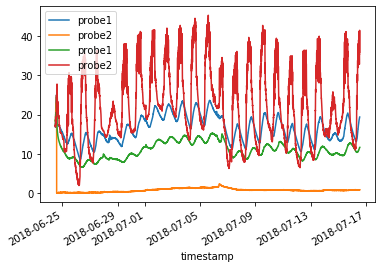

In [2]:
import pandas as pd
from pandas import Series
import numpy as np

sensor811 = pd.read_excel("../Insulation/SN 20103811 2018-07-16 13_18_09 -0400.xlsx",sheet_name="DATA",
                          header=1,date_parser=[1],names=["#","timestamp","probe1","probe2"])
sensor811 = sensor811.set_index('timestamp')
sensor811 = sensor811.drop("#",axis=1)
sensor934 = pd.read_excel("../Insulation/SN 20366934 2018-07-16 13_19_37 -0400.xlsx",sheet_name="DATA",
                          header=1,date_parser=[0],names=["#","timestamp","probe1","probe2"])
sensor934 = sensor934.set_index('timestamp')
sensor934 = sensor934.drop("#",axis=1)
# print(sensor811.timestamp)
ax = sensor811.plot()
sensor934.plot(ax = ax)

alt0 = np.copy(sensor811.probe2)
alt30 = np.copy(sensor811.probe1)
alt10 = np.copy(sensor934.probe1)
alt46 = np.copy(sensor934.probe2)


#### Start/end time + number of data point

In [3]:
tstart = sensor811.index[0]
print(tstart)
n = sensor811.shape[0]
print(n)
tend = sensor811.index[n-1]
print(tend)
print(pd.Timedelta(tend-tstart))

2018-06-24 11:53:58
6353
2018-07-16 13:13:58
22 days 01:20:00


## Time Constants

In [4]:
dt = 5*60.

dt_2 = dt / 2
oneday = 24*3600
Sim_time = 22*oneday

Nt = int(Sim_time/dt)
print(oneday)

86400


## Grid

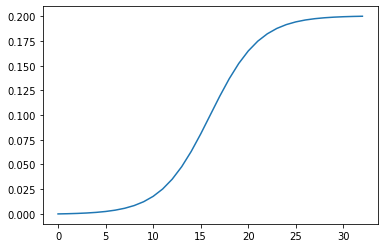

In [5]:
import numericaltools as numtools
import matplotlib.pyplot as plt

def create_grid(nz,lz,dzmin):
    z,gz = numtools.stretched_mesh(lz,nz,dzmin,28)
    
    dz = numtools.nufd(z)
    a_metrics = np.zeros(nz-2)
    c_metrics = np.zeros(nz-2)
    a_metrics[:] = 1. / ((z[1:-1] - z[0:-2])*(z[2:]-z[0:-2]))
    c_metrics[:] = 1. / ((z[2:] - z[1:-1])*(z[2:]-z[0:-2]))
    return z,dz,a_metrics,c_metrics
nz = 33
lz = 0.2
dzmin = lz/1000
z,dz,a_metrics,c_metrics = create_grid(nz,lz,dzmin)
plt.plot(z)
plt.show()
Dz = numtools.nufd(z)

## Simulation

In [6]:
from scipy.interpolate import interp1d
z10 = np.array([0.1])

In [7]:
'''
input: z, T_bot, T_top
output: Temperature based on 1-D heat transfer???
'''
def temperature_initialization(z,T_bot,T_top):
    return T_bot + (T_top - T_bot)*(z/z[-1]) 

In [8]:
""" 
inputs: 
alpha, vector, dimension 2, alpha[0]: curing concrete blanket thermal diffusivity, alpha[1]: mulch
L_ccb: thickness curing concrete blanket
start_time: t=0 for simulation
end_time: end of simulation
"""
def cst_diffusivity_sim(alpha,L_ccb,start_time,end_time):
    global z,dt, dt_2, Sim_time, Nt, z10, a_metrics, c_metrics,alt0,alt30,Dz

    a_rhs = np.zeros(nz-2)
    b_rhs = np.zeros(nz-2)
    c_rhs = np.zeros(nz-2)
    a_lhs = np.zeros(nz-2)
    b_lhs = np.zeros(nz-2)
    c_lhs = np.zeros(nz-2)

    Tprofiles = np.zeros((nz,Nt+1))
    T10 = np.zeros(Nt+1)


    def bottom_T(i):
        global alt0
        return alt0[i]
    def top_T(i):
        global alt30
        return alt30[i]
    mask_ccb = np.where(z < L_ccb)
    alpha_total_all = alpha[1]*np.ones(nz)
    alpha_total_all[mask_ccb] = alpha[0]
    istart = int(start_time/dt)
    i = istart
    T = temperature_initialization(z,alt0[i],alt30[i])
    a_lhs, b_lhs, c_lhs = numtools.diffusion_matrix_coefficients(alpha_total_all,dt_2,a_metrics,c_metrics)
    isample = 0
    Sim_t = start_time
#     T[0] = bottom_T(i)
#     T[-1] = top_T(i)
    if end_time > Sim_time:
        stop
    while Sim_t < end_time:

        Sim_t += dt
        a_rhs = np.copy(a_lhs)
        b_rhs = np.copy(b_lhs)
        c_rhs = np.copy(c_lhs)

        T_old = np.copy(T)
        T[0] = bottom_T(i)
        T[-1] = top_T(i)

        error = np.inf
        Titold = np.copy(T)
        j = 0
        while error > 1e-5 and j < 100:
            a_lhs, b_lhs, c_lhs = numtools.diffusion_matrix_coefficients(alpha_total_all,dt_2,a_metrics,c_metrics)
            d = numtools.rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_old, T,dt_2,dt)
            T[1:-1] = numtools.TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)
            error = np.linalg.norm(T-Titold,2)/np.mean(T)
            Titold = np.copy(T)
            j += 1
#             print(j,error)
        i += 1
        f = interp1d(z,T)
        T10[i] = f(z10)
        Tprofiles[:,i] = np.copy(T)
#         print(i,Sim_t/Sim_time*100)
#         clear_output(wait=True)
    return T10,Tprofiles

# Pymoo

## Problem Class

In [9]:
import numpy as np
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

class thermal_diff_prob(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=1,
                         n_constr=2,
                         xl=np.array([-7,-7.5]),
                         xu=np.array([-6,-6.5]))

    def _evaluate(self, x, out, *args, **kwargs):
          
        # FUNCTION
        #alpha_mulch = x[:,0]
        #alpha_blanket = x[:,1]
        
        # Simulation    
        #########################################################################
        L_ccb = 0.0254
        #x = np.array([alpha_ccb, alpha_mulch])
        alpha_mulch = x[:,0]
        alpha_ccb = x[:,1]
        x = np.array([alpha_ccb, alpha_mulch])
        nz = 33
        lz = 0.2
        dzmin = lz/100
        start_time = 0*oneday
        end_time = 22*oneday
        istart = int(start_time/dt)
        iend = int(end_time/dt)
        z,dz,a_metrics,c_metrics = create_grid(nz,lz,dzmin)
        T10,Tprofiles = cst_diffusivity_sim(x,L_ccb,start_time,end_time)
        #########################################################################
        
        T_sim = T10 
        
        # Experiment
        # get_probe_data()
        # run get experimental data cell above
        T_exp = alt10 # array of temps over time @ 10cm
        
        out["F"] = np.abs(T_sim - T_exp)
        #f1 = x[:,0]**2 + x[:,1]**2
        #f2 = (x[:,0]-1)**2 + x[:,1]**2

        # Constaints (Normalized?)
        #g1 = 2*(x[:, 0]-0.1) * (x[:, 0]-0.9) / 0.18
        #g2 = - 20*(x[:, 0]-0.4) * (x[:, 0]-0.6) / 4.8

        #out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1, g2])
        
    # --------------------------------------------------
    # Pareto-front - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_front(self, flatten=True, **kwargs):
        f1_a = np.linspace(0.1**2, 0.4**2, 100)
        f2_a = (np.sqrt(f1_a) - 1)**2

        f1_b = np.linspace(0.6**2, 0.9**2, 100)
        f2_b = (np.sqrt(f1_b) - 1)**2

        a, b = np.column_stack([f1_a, f2_a]), np.column_stack([f1_b, f2_b])
        return stack(a, b, flatten=flatten)

    # --------------------------------------------------
    # Pareto-set - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_set(self, flatten=True, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)

        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)

problem = thermal_diff_prob()

## Algorithm

In [10]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

## Termination

In [11]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 40)

## Solve

In [12]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=False)

ValueError: operands could not be broadcast together with shapes (40,) (33,) 

In [13]:
print(alpha[1])

NameError: name 'alpha' is not defined

## Visualize

In [ ]:
from pymoo.visualization.scatter import Scatter

# get the pareto-set and pareto-front for plotting
ps = problem.pareto_set(use_cache=False, flatten=False)
pf = problem.pareto_front(use_cache=False, flatten=False)

# Design Space
plot = Scatter(title = "Design Space", axis_labels="x")
plot.add(res.X, s=30, facecolors='none', edgecolors='r')
plot.add(ps, plot_type="line", color="black", alpha=0.7)
plot.do()
plot.apply(lambda ax: ax.set_xlim(-0.5, 1.5))
plot.apply(lambda ax: ax.set_ylim(-2, 2))
plot.show()

# Objective Space
plot = Scatter(title = "Objective Space")
plot.add(res.F)
plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show()